### Exploring Non-Gaussianity and Feature Normalization 

In [1]:
from data import Portfolio, Dataset
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

We again start by instantiating our Portfolio object. We are simply interested in a single feature, so we use our favorite technology stock, AAPL.

In [2]:
# define stock list of portfolio (just AAPL in this case)
stock_list = ['AAPL']

# define desired start and end dates
start = '1990-01-01'
end = '2020-01-01'

# construct pandas dataframe of portfolio returns to instantiate Portfolio object 
# (in this case from yfinance)
returns = yf.Ticker('^DJI').history(start=start,end=end)

# construct Portfolio object implemented in data.py
dji = Portfolio('^DJI', stock_list, returns, start=start,end=end)

We next define our features using our stocks and periods, the target, the forward return horizon, target name, and task type (regression or classification)

In [7]:
# define feature names, target name, periods
feature_names = stock_list
target_name = 'returns'
periods = list(range(1,21)) + list(range(40,260,20))
horizon = 5

params = {'pfolio_obj': dji, 
          'data_type': 'Close', 
          'feature_names': stock_list, 
          'periods': periods, 
          'horizon': horizon, 
          'target_name': 'returns', 
          'task_type': 'classification'}

# instantiate data object 
dji_data = Dataset(**params)

In [11]:
display(dji_data.df.head())

,"(AAPL, 1)","(AAPL, 2)","(AAPL, 3)","(AAPL, 4)","(AAPL, 5)","(AAPL, 6)","(AAPL, 7)","(AAPL, 8)","(AAPL, 9)","(AAPL, 10)",...,"(AAPL, 80)","(AAPL, 100)","(AAPL, 120)","(AAPL, 140)","(AAPL, 160)","(AAPL, 180)","(AAPL, 200)","(AAPL, 220)","(AAPL, 240)",returns
Date,,,,,,,,,,,,,,,,,,,,,
1990-12-13,0.025862,0.017094,-0.024590,-0.040323,-0.016529,0.017094,0.053097,0.072072,0.112150,0.112150,...,0.122642,-0.024590,-0.008333,0.025862,0.053097,0.000000,0.202020,0.214286,0.101852,1.0
1990-12-14,-0.016807,0.008621,0.000000,-0.040984,-0.056452,-0.033058,0.000000,0.035398,0.054054,0.093458,...,0.147059,-0.048780,-0.008475,-0.016807,0.026316,0.000000,0.193878,0.206186,0.073394,1.0
1990-12-17,0.000000,-0.016807,0.008621,0.000000,-0.040984,-0.056452,-0.033058,0.000000,0.035398,0.054054,...,0.158416,-0.025000,-0.033058,-0.025000,0.017391,0.000000,0.170000,0.181818,0.073394,1.0
1990-12-18,0.059829,0.059829,0.042017,0.068966,0.059829,0.016393,0.000000,0.024793,0.059829,0.097345,...,0.203883,0.033333,-0.008000,0.033333,0.078261,0.024793,0.215686,0.227723,0.127273,1.0
1990-12-19,-0.016129,0.042735,0.042735,0.025210,0.051724,0.042735,0.000000,-0.016129,0.008264,0.042735,...,0.109091,-0.008130,-0.061538,0.033898,0.051724,0.016667,0.184466,0.220000,0.119266,0.0


For the purposes of our exploration, we only hone in on one feature: WLOG, let us select the 10-day "backward returns" for AAPL.

In [16]:
feature = dji_data.df[('AAPL', 10)]

We first get the statistics of this feature, including kurtosis and skewness:

In [18]:
df_stats = feature.describe()

df_stats.loc['var'] = feature.var()
df_stats.loc['kurtosis'] = feature.kurtosis()
df_stats.loc['skewness'] = feature.skew()
df_stats = df_stats.reindex(['count', 'mean', 'std', 'var', 'kurtosis', 'skewness', 'min', '25%', '50%', '75%', 'max'])
display(df_stats)

count       7315.000000
mean           0.011452
std            0.087217
var            0.007607
kurtosis       6.202234
skewness      -0.021948
min           -0.628032
25%           -0.036696
50%            0.010766
75%            0.057911
max            0.836735
Name: (AAPL, 10), dtype: float64

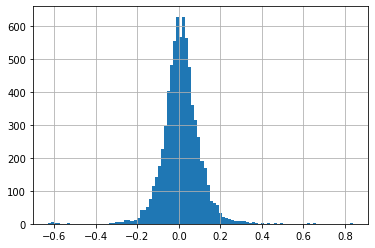

In [28]:
# histogram of returns
hist = feature.hist(bins=100)

The kurtosis of this feature is 6.202, which is greater than the kurtosis of 3 for a univariate Gaussian, making it leptokurtic-it has as a result fatter tails, which is probably expected in backward return distributions.

We can now generate a qq plot for this data

In [ ]:
Dataframe[‘feature1ExpandingNorm’]=(Dataframe[‘feature1’]-dataframe[‘feature1’].expanding.mean())/dataframe[‘feature1’].expanding().std()